In [234]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [235]:
import numpy as np
import pandas as pd

In [236]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [237]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func 

In [238]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [239]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [240]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [241]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [242]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [243]:
# Display the row's columns and data in dictionary format
measurement_first_row = session.query(Measurement).first()
measurement_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1239573c8>,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08}

In [244]:
# Display the row's columns and data in dictionary format
station_first_row = session.query(Station).first()
station_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x123844588>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'id': 1,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397'}

# Exploratory Climate Analysis

In [317]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

##query_total_dates = session.query(func.count(Measurement.date)).all()# Total dates
##query_earliest_date = session.query(Measurement.date).order_by(Measurement.date).first()# Earliest Date
query_latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()# latest Date
dt_latest_date = dt.datetime.strptime(query_latest_date[0], '%Y-%m-%d')# latest Date in datetime format

#calculate year ago date
year_ago_date = dt_latest_date - dt.timedelta(days=365)
print("latest date:",dt_latest_date,"\n12 months ago date:",year_ago_date)

latest date: 2017-08-23 00:00:00 
12 months ago date: 2016-08-23 00:00:00


In [250]:
# Perform a query to retrieve the data and precipitation scores
prcp_data = (session
 .query(Measurement.date,Measurement.prcp)
 .filter(Measurement.date > year_ago_date)
 .filter(Measurement.prcp>=0)
 .order_by(Measurement.date).all())

Text(0,0.5,'Precipitation')

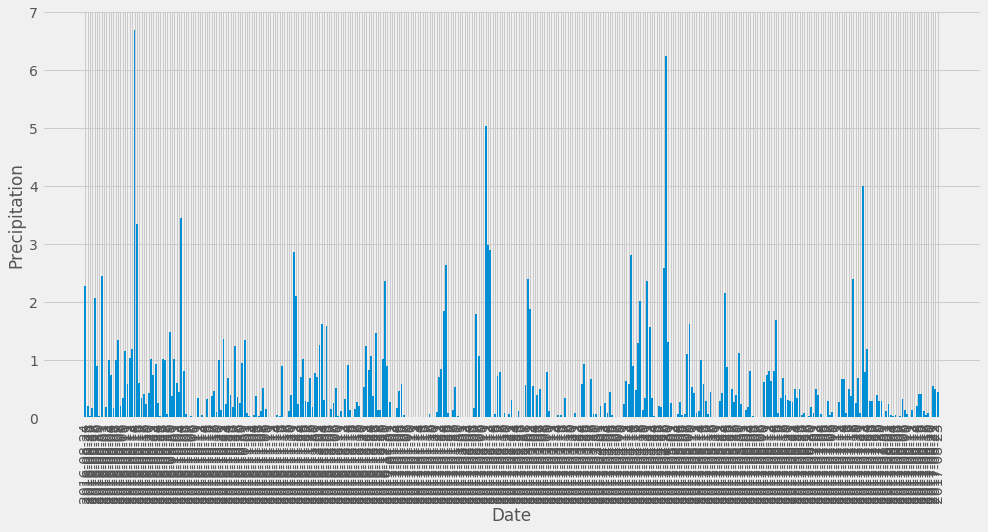

In [252]:
# Plot the Results 
#------------------------------------------

# Save the query results as a Pandas DataFrame
df = pd.DataFrame(prcp_data, columns=['Date', 'Precipitation'])

# set the index to the date column/Sort the dataframe by date
df.set_index('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(15,7))
ax.bar(df.index, df['Precipitation'])
#df.plot(ax=ax)

#set ticks every year
#ax.xaxis.set_major_locator(mdates.YearLocator())
#tick.label.set_fontsize(14) 
#ax.label.set_rotation('vertical')
#set major ticks format
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
plt.xticks(fontsize=14, rotation=90)
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation')
#plt.figure()
#plt.show()

In [253]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [254]:
#  Use Pandas to calcualte the summary statistics for the precipitation data 
max_prcp_date= df[df['Precipitation']==df['Precipitation'].max()].index[0]
max_prcp=df['Precipitation'].max()
min_prcp=df['Precipitation'].min()
avg_prcp=df['Precipitation'].mean()
std_prcp=df['Precipitation'].std()
count_prcp=df['Precipitation'].count()
summary = pd.DataFrame({"Max Prcp Date": max_prcp_date,
                              "Max Prcp": max_prcp,
                              "Min Prcp": min_prcp,
                              "Average Prcp": avg_prcp,
                              "Std Prcp": std_prcp,
                              "Total Days": count_prcp,
                              },index=["Summary"])
summary

,Max Prcp Date,Max Prcp,Min Prcp,Average Prcp,Std Prcp,Total Days
Summary,2016-09-14,6.7,0.0,0.176462,0.460288,2015


In [255]:
# Design a query to show how many stations are available in this dataset?
from sqlalchemy import distinct
total_stations = (session
 .query(func.count(distinct(Measurement.station)))
 .all())
total_stations

[(9)]

In [256]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_list = (session
 .query(Measurement.station, func.count(Measurement.station))
 .group_by(Measurement.station)
 .order_by(func.count(Measurement.station).desc())
 .all())
stations_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [295]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
tobs_stat = (session
 .query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))
 .all())
print("Min Tobs:",tobs_stat[0][0],"\nMax Tobs:",tobs_stat[0][1],"\nAvg Tobs:",tobs_stat[0][2])

Min Tobs: 53.0 
Max Tobs: 87.0 
Avg Tobs: 73.09795396419437


In [296]:
# Choose the station with the highest number of temperature observations.
station_max_no_of_tobs = stations_list[0][0]
station_max_no_of_tobs 

'USC00519281'

In [309]:
# Query the last 12 months of temperature observation data for this station
tobs_data = (session
 .query(Measurement.tobs)
 .filter(Measurement.date > year_ago_date)
 .filter(Measurement.station==station_max_no_of_tobs )
 .order_by(Measurement.tobs).all())
tobs_data

[(59.0),
 (59.0),
 (59.0),
 (60.0),
 (60.0),
 (61.0),
 (62.0),
 (62.0),
 (62.0),
 (62.0),
 (62.0),
 (62.0),
 (63.0),
 (63.0),
 (63.0),
 (63.0),
 (64.0),
 (64.0),
 (64.0),
 (65.0),
 (65.0),
 (65.0),
 (65.0),
 (65.0),
 (65.0),
 (65.0),
 (66.0),
 (66.0),
 (66.0),
 (66.0),
 (66.0),
 (67.0),
 (67.0),
 (67.0),
 (67.0),
 (67.0),
 (67.0),
 (67.0),
 (67.0),
 (67.0),
 (67.0),
 (67.0),
 (67.0),
 (67.0),
 (67.0),
 (67.0),
 (68.0),
 (68.0),
 (68.0),
 (68.0),
 (68.0),
 (68.0),
 (68.0),
 (68.0),
 (68.0),
 (68.0),
 (68.0),
 (68.0),
 (69.0),
 (69.0),
 (69.0),
 (69.0),
 (69.0),
 (69.0),
 (69.0),
 (69.0),
 (69.0),
 (69.0),
 (69.0),
 (69.0),
 (69.0),
 (69.0),
 (69.0),
 (69.0),
 (69.0),
 (69.0),
 (69.0),
 (70.0),
 (70.0),
 (70.0),
 (70.0),
 (70.0),
 (70.0),
 (70.0),
 (70.0),
 (70.0),
 (70.0),
 (70.0),
 (70.0),
 (70.0),
 (70.0),
 (70.0),
 (70.0),
 (70.0),
 (70.0),
 (70.0),
 (70.0),
 (70.0),
 (70.0),
 (71.0),
 (71.0),
 (71.0),
 (71.0),
 (71.0),
 (71.0),
 (71.0),
 (71.0),
 (71.0),
 (71.0),
 (71.0),
 (71.0),
 

Text(0,0.5,'Frequency')

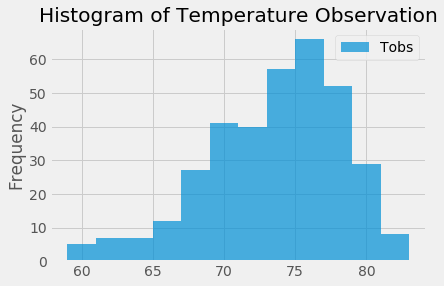

In [338]:
#plot the results as a histogram
df = pd.DataFrame(tobs_data, columns=['Tobs'])
df.plot.hist(bins=12, alpha=0.7)
plt.title("Histogram of Temperature Observation")
#plt.xlabel("Tobs")
plt.ylabel("Frequency")

In [319]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.

    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [320]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

temps = calc_temps('2012-02-28', '2012-03-05')
tmin = temps[0][0]
tavg = temps[0][1]
tmax = temps[0][2]
print("tmin: ",tmin,"\ntavg: ",tavg,"\ntmax: ",tmax)

tmin:  62.0 
tavg:  69.57142857142857 
tmax:  74.0


Text(0,0.5,'Average Temperature')

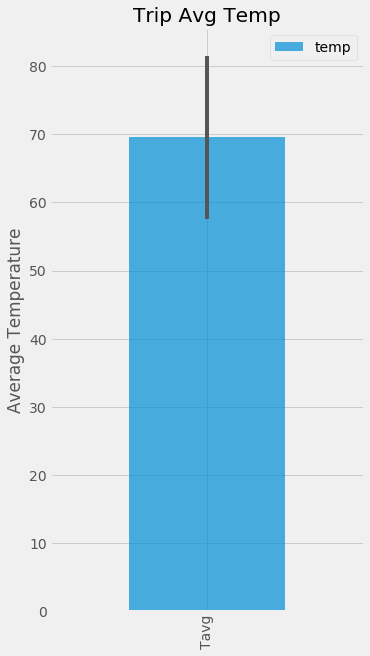

In [343]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df = pd.DataFrame({'name':['Tavg',], "temp":[tavg]})
df.plot.bar(x='name', y='temp', yerr=tmax-tmin,figsize=(5,10),alpha=0.7)
plt.title("Trip Avg Temp")
plt.xlabel("")
plt.ylabel("Average Temperature")

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


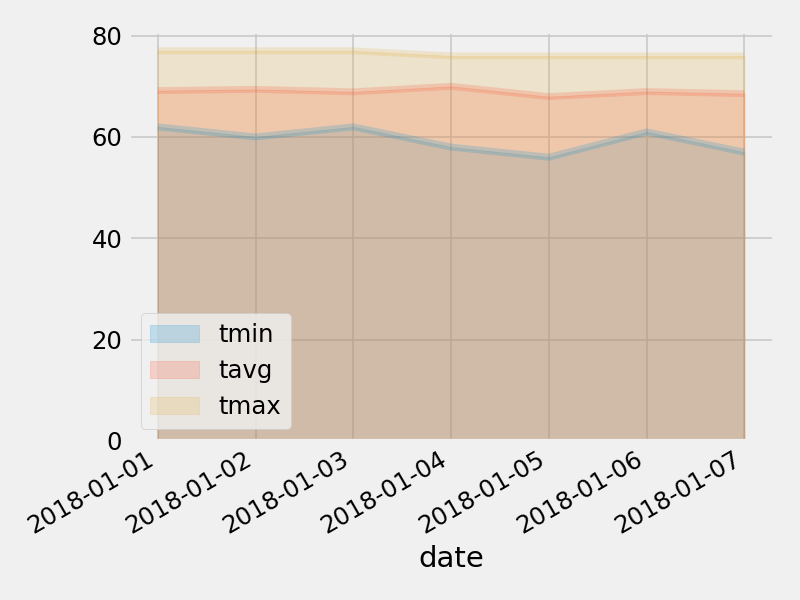

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
